Entrainement de modèles de base et d'un modèle CatModel qui les concatène.  

Les définitions communes sont dans **rakuten_common.py**
  * NB_ECHANTILLONS: Nombre d'échantillons utilisés (-1 par défaut => tous)
  * TEST_SIZE: Ratio utilisé pour les tests (0.2 par défaut)
  * VALIDATION_SPLIT: Ratio utilisé pour la validation (0.15 par défaut)
  * RakutenBaseModel: Classe de base des modèles
  * RakutenCatModel: Classe de base pour les modèles utilisant des modèles de base
  * get_X...: Fonctions diverses retournant des données preprocessées, créant un fichier cache si nécessaire
  
L'exécution d'un modèle se fait ainsi:

        modele().evaluate(NB_ECHANTILLONS)  

Après entrainement et prédiction, un rapport est affiché et le modèle est sauvegardé sur disque.

Un modèle qui utilise des modèles de base déjà exécutés doit les déclarer dans sa fonction **config** (voir CatModel.config())


In [1]:
from rakuten_common import *

In [2]:
class EmbedRNN(RakutenBaseModel):
    """
    
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.maxlen = 600
            self.num_words = 50000
            self.embedding_dim = 200
            self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.num_words)

    def get_class_weight(self):
        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
        cw = {i: 1 for i in range(NB_CLASSES)}
        #cw[indices[1280]] = 2
        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.maxlen,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.Embedding(self.num_words, self.embedding_dim,
                                      name=self.layer_name("embed"))(inp)
        x = tf.keras.layers.GRU(128, return_sequences=True,
                                name=self.layer_name("gru"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.GlobalAveragePooling1D(name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dense(256, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text(input_file)[off_start:off_end]
        self.tokenizer.fit_on_texts(X_train)
        self.word2idx = self.tokenizer.word_index
        self.idx2word = self.tokenizer.index_word
        self.vocab_size = self.tokenizer.num_words
        
        X_train = self.tokenizer.texts_to_sequences(X_train)
        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                                maxlen=self.maxlen,
                                                                padding='post')
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = self.tokenizer.texts_to_sequences(X_test)
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                               maxlen=self.maxlen,
                                                               padding='post')

        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3,
                                          class_weight=[])

++ [07h07mn] EmbedRNN: Evaluation avec 84916 échantillons
++ [07h07mn] EmbedRNN: fit(): Début
Epoch 1/50
1805/1805 [==============================] - 303s 164ms/step - loss: 1.5405 - accuracy: 0.5354 - val_loss: 0.7926 - val_accuracy: 0.7613
Epoch 2/50
1805/1805 [==============================] - 295s 163ms/step - loss: 0.5954 - accuracy: 0.8244 - val_loss: 0.6083 - val_accuracy: 0.8197
Epoch 3/50
1805/1805 [==============================] - 291s 161ms/step - loss: 0.3360 - accuracy: 0.8987 - val_loss: 0.6714 - val_accuracy: 0.8184
Epoch 4/50
1805/1805 [==============================] - 291s 162ms/step - loss: 0.1956 - accuracy: 0.9404 - val_loss: 0.7996 - val_accuracy: 0.8115
Epoch 5/50
1805/1805 [==============================] - 292s 162ms/step - loss: 0.1252 - accuracy: 0.9613 - val_loss: 0.9616 - val_accuracy: 0.8079

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
1805/1805 [==============================] - 291s 161ms/step - loss: 0.05

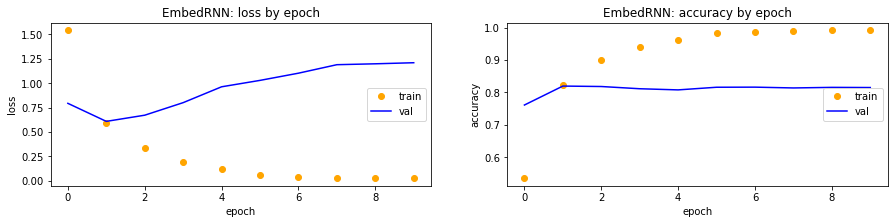

++ [07h56mn] EmbedRNN: fit(): Fin

++ [07h56mn] EmbedRNN: predict(): Début
531/531 [==============================] - 10s 18ms/step
++ [07h57mn] EmbedRNN: predict(): Fin

++ [07h57mn] EmbedRNN: w-f1-score = 0.8132

              precision    recall  f1-score   support

          10       0.55      0.58      0.56       652
        1140       0.73      0.75      0.74       541
        1160       0.94      0.92      0.93       815
        1180       0.63      0.46      0.53       140
        1280       0.68      0.72      0.70       956
        1281       0.59      0.56      0.58       399
        1300       0.96      0.94      0.95      1051
        1301       0.93      0.85      0.88       168
        1302       0.73      0.82      0.77       497
        1320       0.84      0.76      0.80       683
        1560       0.81      0.83      0.82       993
        1920       0.93      0.90      0.91       841
        1940       0.75      0.88      0.81       147
        2060       0.80     

In [8]:
EmbedRNN().evaluate(NB_ECHANTILLONS)

In [3]:
class Multilingu(RakutenBaseModel):
    """
    Modèle de plongement (embedding) dans un modèle de texte préentrainé
    (Multilingual-large)
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.embedding_length = 512 # Défini par le modèle Multilingual/large
            self.std = StandardScaler()

    def get_class_weight(self):
        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
        cw = {i: 1 for i in range(NB_CLASSES)}
        #cw[indices[1280]] = 2
        #cw[indices[10]] = 1.5
        #cw[indices[2060]] = 1.5
        #cw[indices[1560]] = 1.5
        #cw[indices[1281]] = 1.5
        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
        x = tf.keras.layers.Dense(200, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
#        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
#        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3,
                                          class_weight=self.get_class_weight())
        


++ [19h17mn] Multilingu: Evaluation avec 84916 échantillons
++ [19h17mn] Multilingu: fit(): Début
Epoch 1/50
1805/1805 [==============================] - 4s 2ms/step - loss: 1.4927 - accuracy: 0.5855 - val_loss: 0.7492 - val_accuracy: 0.7637
Epoch 2/50
1805/1805 [==============================] - 4s 2ms/step - loss: 0.8639 - accuracy: 0.7341 - val_loss: 0.7035 - val_accuracy: 0.7774
Epoch 3/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.7909 - accuracy: 0.7562 - val_loss: 0.6888 - val_accuracy: 0.7834
Epoch 4/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.7571 - accuracy: 0.7604 - val_loss: 0.6737 - val_accuracy: 0.7833
Epoch 5/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.7141 - accuracy: 0.7726 - val_loss: 0.6638 - val_accuracy: 0.7886
Epoch 6/50
1805/1805 [==============================] - 3s 2ms/step - loss: 0.6934 - accuracy: 0.7787 - val_loss: 0.6738 - val_accuracy: 0.7908
Epoch 7/50
1805/1805 [================

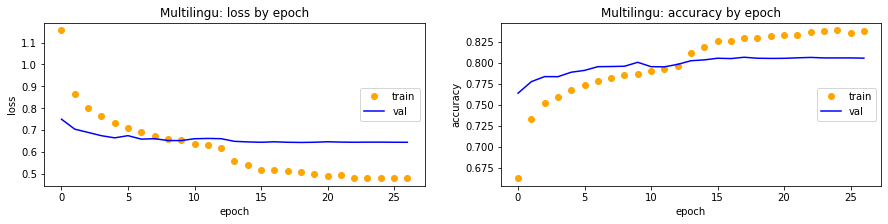

++ [19h19mn] Multilingu: fit(): Fin

++ [19h19mn] Multilingu: predict(): Début
531/531 [==============================] - 0s 859us/step
++ [19h19mn] Multilingu: predict(): Fin

++ [19h19mn] Multilingu: w-f1-score = 0.8055

              precision    recall  f1-score   support

          10       0.57      0.64      0.60       652
        1140       0.70      0.74      0.72       541
        1160       0.91      0.92      0.92       815
        1180       0.68      0.56      0.61       140
        1280       0.61      0.60      0.61       956
        1281       0.67      0.48      0.56       399
        1300       0.82      0.93      0.87      1051
        1301       0.97      0.84      0.90       168
        1302       0.74      0.74      0.74       497
        1320       0.78      0.72      0.75       683
        1560       0.77      0.80      0.78       993
        1920       0.87      0.89      0.88       841
        1940       0.91      0.95      0.93       147
        2060       0

In [40]:
Multilingu().evaluate(NB_ECHANTILLONS)

In [4]:
class NPDataset(tf.keras.utils.Sequence):
    """
    Générateur qui extrait les données (de type tableau numpy)
    à partir d'un path de fichier
    """
    def __init__(self, batch_size,
                 X, y=None, shuffle=False, random_state=1968):
        nb = len(X)
        self.y = y
        self.batch_size = batch_size
        self.batch_number = int(nb / batch_size)
        self.batch_indexes = range(self.batch_number)
        self.prefix = re.match(r'^(.*)_\d+\.npy$', X[0]).group(1)
        if shuffle:
            self.random_state = random_state
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=random_state)
        self.shuffle = shuffle

    def __len__(self):
        """ Retourne le nombre de batchs """
        return self.batch_number

    def __getitem__(self, index):
        index = self.batch_indexes[index]
        X = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            f = f"{self.prefix}_{i}.npy"
            with open(f, 'rb') as fd:
                x = np.load(fd)
                X.append(x)
        X = np.array(X)
        if self.y is None:
            return X
        else:
            y = self.y[index*self.batch_size : (index+1)*self.batch_size]
            return X, y

    def on_epoch_end(self):
        """ Changements effectués à chaque fin d'époque """
        if self.shuffle:
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=self.random_state)
        

class TextOneHot(RakutenBaseModel):
    """
    Mini modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn <TfidfVectorizer | SelectFromModel(LinearSVC)>
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "select"):
            # Appel pour la création du modèle
            self.privatedir = os.path.join(OUTDIR, self.name)
            self.maxfeatures = 50000 # Nombre de features selectionnées par SVC
            self.select = make_pipeline(
                TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  #    tokenizer=tokenize_spacy, # les données sont déjà tokenizées
                  preprocessor=' '.join,
                  lowercase=False,
                  stop_words=None,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def __flush_data_to_file(self, data, tag, off_start, off_end, input_file=None):
        if not os.path.isdir(self.privatedir):
            os.makedirs(self.privatedir)
        filelist = []
        for i in range(data.shape[0]):
            f = os.path.join(self.privatedir,
                             f"{tag}_{off_start}_{off_end}_{i}.npy")
            with open(f, 'wb') as fd:
                datum = data[i].toarray()[0]
                np.save(fd, datum)
            filelist.append(f)
        return filelist
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une donnée preprocessée à partir d'un fichier
        et la retourner
        """
        with open(filepath, 'rb') as fd:
            datum = np.load(fd)
        return datum

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=self.input_shape, name=self.layer_name("input"))
        x = inp
        x = tf.keras.layers.Dense(90, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train = get_y()[off_start:off_end]
#            X_train = get_X_text(input_file)[off_start:off_end]
        X_train = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train)
        self.input_shape = X_train.shape[1:]
        self.prt(f"Nombre de mots retenus = {self.input_shape[0]}")
        return self.__flush_data_to_file(X_train, "train", off_start, off_end)

    def preprocess_X_test(self, off_start, off_end, input_file=None):
#        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test)
        return self.__flush_data_to_file(X_test, "test", off_start, off_end)

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)
        trainds = NPDataset(self.batch_size, X_train, y_train, shuffle=True)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)
        valds = NPDataset(self.batch_size, X_val, y_val, shuffle=True)

        self.model = self.get_model()

        return self.compile_and_train_dataset(trainds, valds,
                                              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                                              epochs=50,
                                              patience_stop=7, patience_lr=4)

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testds = NPDataset(1, X_test, shuffle=False)
        return self.model_predict(testds)



++ [14h44mn] TextOneHot: Evaluation avec 84916 échantillons
++ [14h44mn] TextOneHot: Nombre de mots retenus = 50000
++ [14h48mn] TextOneHot: fit(): Début
Epoch 1/50
1804/1804 [==============================] - 227s 125ms/step - loss: 2.2109 - accuracy: 0.4851 - val_loss: 0.8102 - val_accuracy: 0.8048
Epoch 2/50
1804/1804 [==============================] - 225s 125ms/step - loss: 0.7465 - accuracy: 0.8351 - val_loss: 0.5861 - val_accuracy: 0.8337
Epoch 3/50
1804/1804 [==============================] - 229s 127ms/step - loss: 0.4084 - accuracy: 0.9096 - val_loss: 0.5266 - val_accuracy: 0.8468
Epoch 4/50
1804/1804 [==============================] - 222s 123ms/step - loss: 0.2462 - accuracy: 0.9472 - val_loss: 0.5181 - val_accuracy: 0.8508
Epoch 5/50
1804/1804 [==============================] - 229s 127ms/step - loss: 0.1592 - accuracy: 0.9661 - val_loss: 0.5294 - val_accuracy: 0.8489
Epoch 6/50
1804/1804 [==============================] - 229s 127ms/step - loss: 0.1091 - accuracy: 0.9779 

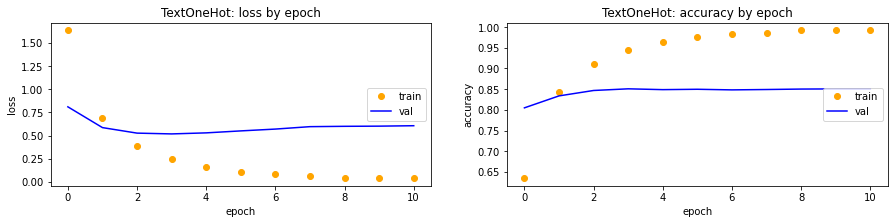

++ [15h30mn] TextOneHot: fit(): Fin

++ [15h30mn] TextOneHot: predict(): Début
16984/16984 [==============================] - 46s 3ms/step
++ [15h31mn] TextOneHot: predict(): Fin

++ [15h31mn] TextOneHot: w-f1-score = 0.8468

              precision    recall  f1-score   support

          10       0.54      0.67      0.60       652
        1140       0.79      0.81      0.80       541
        1160       0.95      0.94      0.95       815
        1180       0.84      0.65      0.73       140
        1280       0.73      0.76      0.74       956
        1281       0.67      0.60      0.63       399
        1300       0.94      0.96      0.95      1051
        1301       0.99      0.90      0.94       168
        1302       0.88      0.83      0.86       497
        1320       0.89      0.83      0.86       683
        1560       0.84      0.86      0.85       993
        1920       0.91      0.93      0.92       841
        1940       0.91      0.93      0.92       147
        2060     

In [4]:
TextOneHot().evaluate(NB_ECHANTILLONS)

In [5]:
class EffNet(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = None # Inclus dans le modèle
        self.basetrainable = 8
        self.epochs_freezed = 10
        self.epochs_unfreezed = 10
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.EfficientNetB1(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train_dataset(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train_dataset(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testgen = self.__get_test_dataset(X_test)
        return self.model_predict(testgen)


In [1]:
EffNet().evaluate(NB_ECHANTILLONS)

In [6]:
class Xception(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3)
        self.preprocessing_function = tf.keras.applications.xception.preprocess_input
        self.basetrainable = 4
        self.epochs_freezed = 10
        self.epochs_unfreezed = 6
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.Xception(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Flatten(name=self.layer_name("flatten"))(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, name=self.layer_name("batchnorm"))(x)        
        x = tf.keras.layers.Dropout(0.35, name=self.layer_name("dropout"))(x)  
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)       
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(256, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.25, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(128, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
#                                    rescale = 1./255,
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.15,
                                    height_shift_range = 0.15,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator(
#                        rescale = 1./255,
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train_dataset(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train_dataset(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testgen = self.__get_test_dataset(X_test)
        return self.model_predict(testgen)


In [7]:
class CatModel(RakutenCatModel):
    """
    Modèle qui concatene plusieurs modèles de base
    """
    def config(self, nb):
        """ Déclaration des modèles de base utilisés """
        if not hasattr(self, "objs") and nb is not None:
            self.objs = [
                         EmbedRNN(nb),
                         #TextOneHot(nb),
                         Multilingu(nb),
                         Xception(nb),
                         #EffNet(nb)
                        ]

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)

        self.config(nb)
        
    def fit(self, off_start, off_val, off_end, input_file=None):
        """
        Entrainement du modèle sur l'intervalle des données spécifié par
        off_start et off_end (offsets dans les fichiers de data).
        """

        self.prt(f'Chargements des modèles référencés "{self.nb}"')
        self.config(self.nb)

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_val, off_end, input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputlayers, outputlayers = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body()
            inputlayers.append(inp)
            outputlayers.append(outp)
        
        self.layer_index = 0 # compteur utilisé dans get_model_body()
        concatname = self.layer_name("concatenate")
        x = concatenate(outputlayers, axis=-1, name = concatname)
        x = Dense(64, activation='relu', name=self.layer_name("dense"))(x)
        x = Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputlayers, x, name=self.name)

        #print(self.model.summary())

        print(f"  * Layers non entrainables:")
#        for layer in self.model.layers[:-4]:
#            layer.trainable = False
#            print(f"      - {layer.name}")
        for layer in self.model.layers:
            if 0 <= layer.name.find('efficient'):
                layer.trainable = False
                print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=1e-4),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        # Initialisation des poids
        self.copy_submodels_weights()

        self.prt("fit(): Début")    
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=20,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)
        return history
                                  


In [ ]:
CatModel().evaluate(NB_ECHANTILLONS)

++ [11h35mn] CatModel: Evaluation avec 84916 échantillons
++ [11h35mn] CatModel: Chargements des modèles référencés "84916"
Chargement de l'objet (modele_rakuten_out\EmbedRNN_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EmbedRNN_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Xception_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\Xception_84916_model.hdf5)
++ [11h35mn] CatModel: Preprocessing des 67932 données d'entrainement
++ [11h35mn] CatModel: Instantiation des générateurs d'entrainement
Nettoyage de modele_rakuten_out\CatDataset_train_57742


  4%|▎         | 64/1804 [00:00<00:02, 634.52it/s]

Création de 1804 fichiers de batch dans modele_rakuten_out\CatDataset_train_57742
* modèle EmbedRNN


  1%|          | 13/1804 [00:00<00:14, 127.35it/s]

* modèle Multilingu


  0%|          | 0/1804 [00:00<?, ?it/s]

* modèle Xception


 27%|██▋       | 493/1804 [06:06<12:56,  1.69it/s]

In [ ]:
# Analyse des mauvaises prédictions à partir du fichier généré
# ne contenant que les mauvaises prédictions
badf = "modele_rakuten_out\CatModel_84916_bad_predictions.csv"
df = pd.read_csv(badf)

print("Classes les plus mal prédites:")
vc = df.y_test.value_counts()
display(pd.DataFrame(vc[:20]).transpose().rename(index = {'y_test': 'Erreurs'}))

plt.figure(figsize=(16,10))
sns.heatmap(pd.crosstab(df.y_test, df.y_pred))
plt.title("Matrice de confusion sur les mauvaise prédictions")
plt.show()

In [ ]:
# Sauvegarde des modèles et création du fichier csv des
# prédictions sur le fichier officiel de test
#CatModel(NB_ECHANTILLONS).deliver()